# *Cloud Storage

https://drive.google.com/drive/folders/1VQgQeyEuADpT82NCIDLzbRKcTOImM1-s?usp=sharing

Files with numeric file names are data from human subjects. You should decompress these files into preproc_data directory which is in practice_2/root_dir.zip .

# *Modules

In [1]:
from glob import glob
import sys
import os
from os.path import join, dirname
# from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

%matplotlib inline

In [2]:
!pip install numpy

You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.


$\textbf{Nilearn}$ enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools : https://nilearn.github.io/

In [3]:
# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

$\textbf{Scikit-learn}$ is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities : https://scikit-learn.org/stable/#

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
# from sklearn.svm import LinearSVC

In [5]:
# from datetime import date
# today = date.today().strftime("%Y%m%d")

# *create variables that point to the location of the configuration

In [6]:
root_dir = '/Users/clmnlab/Desktop/root_dir' # check where the data is downloaded on your disk

In [7]:
preproc_dir = root_dir + '/preproc_data'
mask_dir = root_dir + '/masks'
loc_dir = mask_dir + '/localizer'

# *MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

In [8]:
subj_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
             '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
             '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
stage_list = ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']

In [9]:
def load_betas(subj, stage):
    assert subj in subj_list
    print(subj, end='\r')

    ## betasLSS.G???.r0?.nii.gz
    a, b = stage.split('_')
    assert ((a == 'early')|(a == 'late'))
    assert ((b == 'practice')|(b == 'unpractice'))
    g = 'GA' if a == 'early' else 'GB'
    run_list = ['r01', 'r02', 'r03'] if b == 'practice' else ['r04', 'r05', 'r06']
    
    ## load betas
    temp = {}
    for run in run_list:
        temp[g+subj, run] = niimg.load_img(join(preproc_dir,subj,'betasLSS.%s.%s.nii.gz'%(g+subj,run)))

    ## We suppose to exclude the first slice from the last dimension of this 4D-image
    for key, value in temp.items():
        temp[key] = niimg.index_img(value, np.arange(1, 97))

    ## new arrangement of previous data
    beta = {}
    beta[subj, stage] = niimg.concat_imgs([temp[g+subj, run] for run in run_list])
        
    return beta

In [10]:
subj = '01'
stage = 'late_practice'

In [11]:
beta = load_betas(subj,stage)
print(beta)
print(beta[subj,stage].shape)

{('01', 'late_practice'): <nibabel.nifti1.Nifti1Image object at 0x7fe78b0a3c70>}
(72, 85, 72, 288)


In [12]:
## labeling with target position
# 1 - 5 - 25 - 21 - 1 - 25 - 5 - 21 - 25 - 1 - 21 - 5 - 1 - ...
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

with open(join(root_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
# target_path = list(range(1,13))*8

In [13]:
print('target_pos:\n',target_pos)

target_pos:
 [5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1, 5, 25, 21, 1, 25, 5, 21, 25, 1, 21, 5, 1]


## *Movement-related ROIs from localizer

In [14]:
ROI_imgs = {}
## ROIs
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    ROI_imgs[roi] = niimg.load_img(path)

In [15]:
ROI_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fe78b0a3a00>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bb940>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bbc70>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bbb50>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd0a0>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd430>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd490>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd7f0>}

### *cross validation

Cross-validation can be defined using the “cv” argument. As it is computationally costly, K-Fold cross validation with K = 3 is set as the default. A scikit-learn cross-validation generator can also be passed to set a specific type of cross-validation.

Leave-one-run-out cross-validation (LOROCV) is a common approach. This approach is a specific use-case of grouped cross-validation, where the cross-validation folds are determined by the acquisition runs. The held-out fold in a given iteration of cross-validation consist of data from a separate run, which keeps training and validation sets properly independent. For this reason, LOROCV is often recommended. This can be performed by using LeaveOneGroupOut, and then setting the group/run labels when fitting the estimator.

In [16]:
def fast_masking(img, roi):
    # img : data (NIFTI image)
    # roi : mask (NIFTI image)
    # output : (trials, voxels)-dimensional fdata array
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T    # the shape is (trials, voxels) which is to cross-validate for runs

In [17]:
## LDA analysis
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [18]:
def cross_valid(beta, ROI_imgs, estimator):
    # output : A leave-one-run-out cross-validation (LORO-CV) result.
    #          Automatically save it as pickle file to root_dir
    ## set the parameters
    nrun = 3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] ## answer : [5, 25, 21, 1, 25,...]
    group = [i for i in range(nrun) for j in target_pos] ## run number : [0, 0, ..., 1, 1, ..., 2, 2]
    
    ## cross-validation
    scores = {}
    for subj, stage in beta.keys():
        for name, img in ROI_imgs.items():
            print(subj, stage, name, end='\r')
            X = fast_masking(img=beta[subj, stage], roi=img)
            score = cross_validate(estimator=estimator, X=X, y=y, groups=group
                                   , cv=cv, return_estimator=True, return_train_score=True)
            scores[subj, stage, name] = score['test_score']
    return scores

In [19]:
scores = cross_valid(beta, ROI_imgs, estimator)
scores

{('01',
  'late_practice',
  'n200_c1-1_L_M1'): array([0.3125    , 0.35416667, 0.3125    ]),
 ('01',
  'late_practice',
  'n200_c1-2_L_S1'): array([0.4375    , 0.40625   , 0.29166667]),
 ('01',
  'late_practice',
  'n200_c2_R_CerebellumIV-V'): array([0.25      , 0.27083333, 0.26041667]),
 ('01',
  'late_practice',
  'n200_c3_R_Postcentral'): array([0.375     , 0.30208333, 0.28125   ]),
 ('01',
  'late_practice',
  'n200_c4_L_Putamen'): array([0.28125   , 0.28125   , 0.23958333]),
 ('01',
  'late_practice',
  'n200_c5_R_SMA'): array([0.33333333, 0.28125   , 0.22916667]),
 ('01',
  'late_practice',
  'n200_c6_R_CerebellumVIIIb'): array([0.28125   , 0.30208333, 0.3125    ]),
 ('01',
  'late_practice',
  'n200_c7_L_Thalamus'): array([0.22916667, 0.22916667, 0.28125   ])}

### group analysis (Optional)

In [ ]:
betas = {}
for subj in subj_list:
    for stage in stage_list:
        beta = load_betas(subj, stage)
        betas[subj, stage] = beta[subj, stage]

In [ ]:
scores = cross_valid(betas, ROI_imgs, estimator)

In [ ]:
## Save it as .pickle
path = join(root_dir,'n30_dec-acc_move-rel.pkl')
with open(path,"wb") as fw:
    pickle.dump(scores, fw)

### *read the above pickle

In [20]:
path = join(root_dir,'210219_n30_dec-acc_move-rel.pkl')

In [21]:
## Load pickle
with open(path,"rb") as fr:
    scores = pickle.load(file=fr)

In [22]:
scores

{('01',
  'early_practice',
  'n200_c1-1_L_M1'): array([0.375     , 0.375     , 0.35416667]),
 ('01',
  'early_practice',
  'n200_c1-2_L_S1'): array([0.34375   , 0.38541667, 0.34375   ]),
 ('01',
  'early_practice',
  'n200_c2_R_CerebellumIV-V'): array([0.23958333, 0.21875   , 0.32291667]),
 ('01',
  'early_practice',
  'n200_c3_R_Postcentral'): array([0.3125    , 0.29166667, 0.33333333]),
 ('01',
  'early_practice',
  'n200_c4_L_Putamen'): array([0.25      , 0.32291667, 0.20833333]),
 ('01',
  'early_practice',
  'n200_c5_R_SMA'): array([0.33333333, 0.32291667, 0.35416667]),
 ('01',
  'early_practice',
  'n200_c6_R_CerebellumVIIIb'): array([0.32291667, 0.33333333, 0.26041667]),
 ('01',
  'early_practice',
  'n200_c7_L_Thalamus'): array([0.21875   , 0.3125    , 0.27083333]),
 ('01',
  'early_unpractice',
  'n200_c1-1_L_M1'): array([0.21875   , 0.26041667, 0.26041667]),
 ('01',
  'early_unpractice',
  'n200_c1-2_L_S1'): array([0.32291667, 0.35416667, 0.33333333]),
 ('01',
  'early_unpra

### *Data table

In [23]:
def make_wit_df(scroes):
    wit_df = pd.DataFrame(columns=['subj','ROI','visit','mapping','accuracy_1','accuracy_2','accuracy_3','mean_accuracy'])

    for keys, values in scores.items():
        v, m = keys[1].split('_')
        wit_df = wit_df.append(
            {'subj': keys[0]
             ,'ROI': keys[2]
             ,'visit': v
             ,'mapping': m
             ,'accuracy_1': values[0]
             ,'accuracy_2': values[1]
             ,'accuracy_3': values[2]
             ,'mean_accuracy': np.mean(values)}
            , ignore_index=True)
    return wit_df

In [24]:
wit_df = make_wit_df(scores)
wit_df

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,n200_c1-1_L_M1,early,practice,0.375000,0.375000,0.354167,0.368056
1,01,n200_c1-2_L_S1,early,practice,0.343750,0.385417,0.343750,0.357639
2,01,n200_c2_R_CerebellumIV-V,early,practice,0.239583,0.218750,0.322917,0.260417
3,01,n200_c3_R_Postcentral,early,practice,0.312500,0.291667,0.333333,0.312500
4,01,n200_c4_L_Putamen,early,practice,0.250000,0.322917,0.208333,0.260417
...,...,...,...,...,...,...,...,...
955,44,n200_c3_R_Postcentral,late,unpractice,0.302083,0.312500,0.302083,0.305556
956,44,n200_c4_L_Putamen,late,unpractice,0.281250,0.250000,0.250000,0.260417
957,44,n200_c5_R_SMA,late,unpractice,0.239583,0.312500,0.302083,0.284722
958,44,n200_c6_R_CerebellumVIIIb,late,unpractice,0.322917,0.291667,0.229167,0.281250


### t-test (Optional)

In [25]:
def wit_df_paired_t_test(wit_df, cond_A, cond_B):
    ## cond_A vs. cond_B :
    ### early_practice vs. late_practice
    ### early_unpractice vs. late_unpractice
    ### early_practice vs. early_unpractice
    ### late_practice vs. late_unpractice
    a1, a2 = cond_A.split('_')
    assert a1 in ['early', 'late']
    assert a2 in ['practice', 'unpractice']
    b1, b2 = cond_B.split('_')
    assert b1 in ['early', 'late']
    assert b2 in ['practice', 'unpractice']

    pvals = {}
    
    ROI_list = wit_df.ROI.unique()
    for roi in ROI_list:
        A = wit_df[(wit_df.ROI==roi)&(wit_df.visit==a1)&(wit_df.mapping==a2)]['mean_accuracy']
        B = wit_df[(wit_df.ROI==roi)&(wit_df.visit==b1)&(wit_df.mapping==b2)]['mean_accuracy']
        ttest = scipy.stats.ttest_rel(A, B)
        pvals[roi,cond_A+'/'+cond_B] = statsmodels.stats.multitest.fdrcorrection(ttest.pvalue)
        
    return pvals

In [26]:
wit_df_paired_t_test(wit_df=wit_df, cond_A='early_practice', cond_B='late_unpractice')

{('n200_c1-1_L_M1', 'early_practice/late_unpractice'): (array([False]),
  array([0.50014106])),
 ('n200_c1-2_L_S1', 'early_practice/late_unpractice'): (array([False]),
  array([0.15423584])),
 ('n200_c2_R_CerebellumIV-V',
  'early_practice/late_unpractice'): (array([False]), array([0.29390769])),
 ('n200_c3_R_Postcentral', 'early_practice/late_unpractice'): (array([False]),
  array([0.1966898])),
 ('n200_c4_L_Putamen', 'early_practice/late_unpractice'): (array([False]),
  array([0.20680415])),
 ('n200_c5_R_SMA', 'early_practice/late_unpractice'): (array([ True]),
  array([0.00549199])),
 ('n200_c6_R_CerebellumVIIIb',
  'early_practice/late_unpractice'): (array([False]), array([0.29284652])),
 ('n200_c7_L_Thalamus', 'early_practice/late_unpractice'): (array([False]),
  array([0.08157081]))}

### *Drawing figures

In [27]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA','#C5C7D2']

def draw_lineplot(wit_df, roi_name, title, ax=None):
    
    sub_df = wit_df[wit_df.ROI == roi_name]
    ax = sns.pointplot(x='visit', y='mean_accuracy', hue='mapping', data=sub_df, ax=ax
                       , palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.70,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

In [28]:
ROI_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fe78b0a3a00>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bb940>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bbc70>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fe78b0bbb50>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd0a0>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd430>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd490>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7fe78b0cd7f0>}

In [31]:
## background image
img_bg = join(root_dir,'mni152_2009bet.nii.gz')

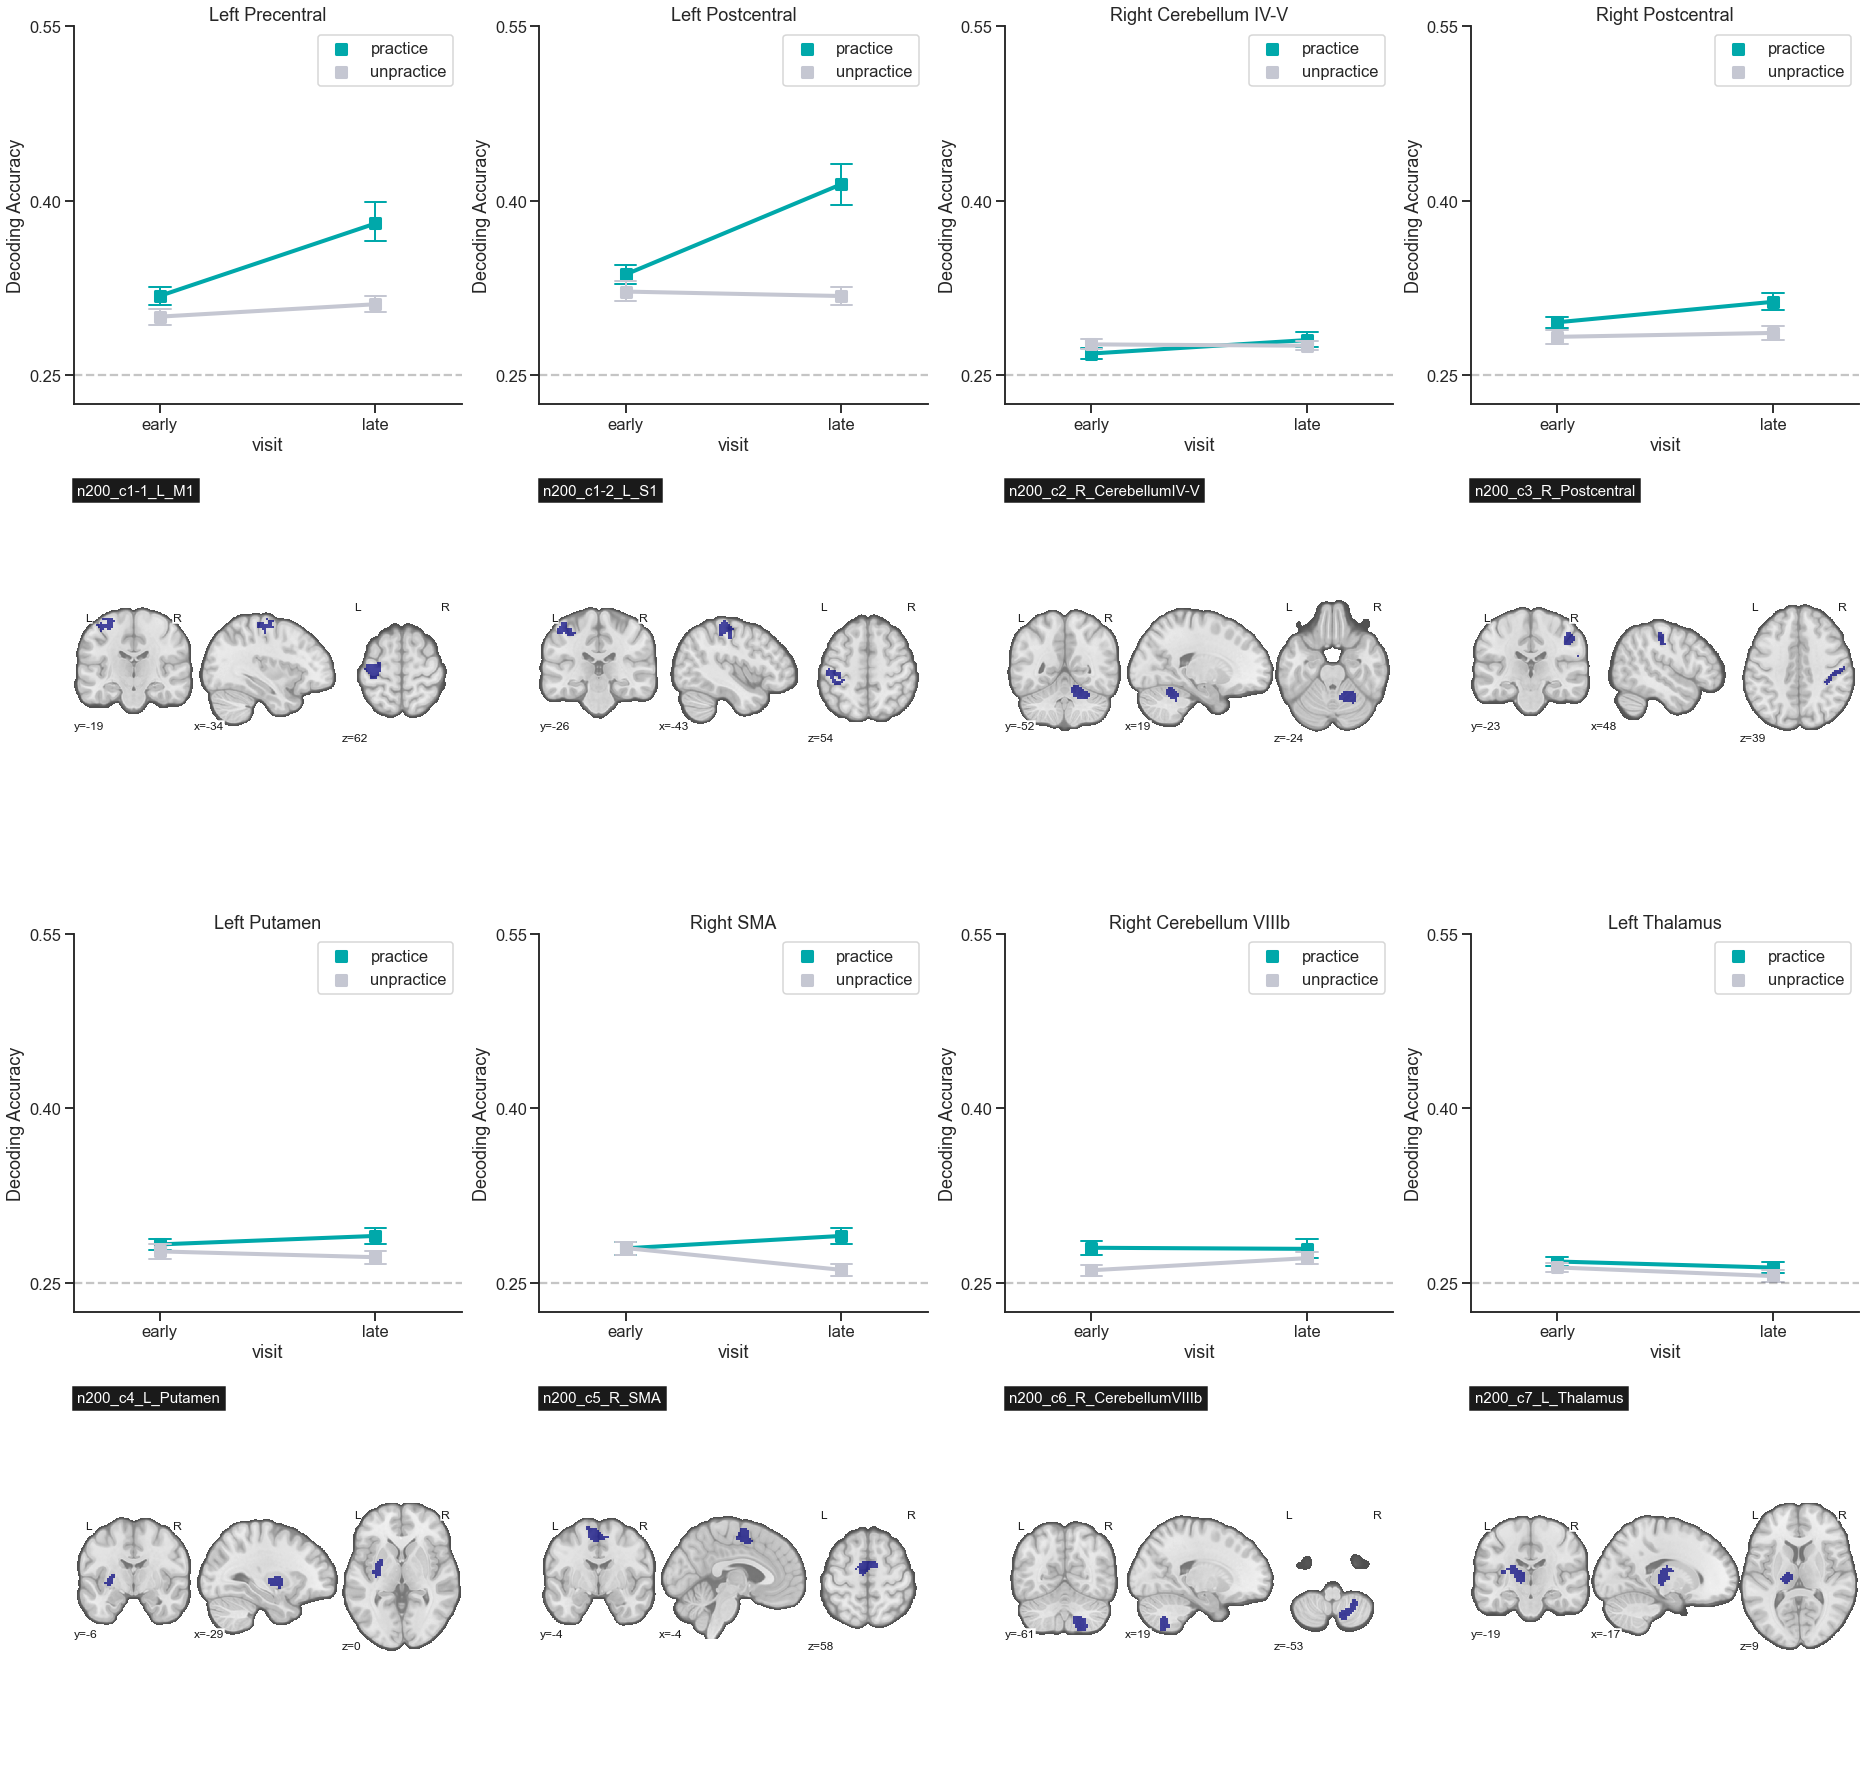

In [30]:
title_list = ['Left Precentral'
              , 'Left Postcentral'
              , 'Right Cerebellum IV-V'
              , 'Right Postcentral'
              , 'Left Putamen'
              , 'Right SMA'
              , 'Right Cerebellum VIIIb'
              , 'Left Thalamus']
ncol = 4
nrow = 4
magn = 8
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
for i, (name, img) in enumerate(ROI_imgs.items()):
    print(name, end='\r')
    ax = draw_lineplot(wit_df, roi_name=name, title=title_list[i], ax=axes[i+(i//ncol)*ncol])
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=name
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i+(i//ncol)*ncol+ncol])

## *SearchLight

Searchlight analysis was introduced in Information-based functional brain mapping (Kriegeskorte et al., 2006), and consists of scanning the brain with a $\textit{searchlight}$. Briefly, a ball of given radius is scanned across the brain volume and the prediction accuracy of a classifier trained on the corresponding voxels is measured.

SearchLight will iterate on the volume and give a score to each voxel. This score is computed by running a classifier on selected voxels. In order to make this score as accurate as possible (and avoid overfitting), cross-validation is used.

An important parameter is the radius of the sphere that will run through the data. The sphere size determines the number of voxels/features to use for classification (i.e. more voxels are included with larger spheres).

In [32]:
def run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level):

    searchlight = nilearn.decoding.SearchLight(
        full_mask
        , radius=radius
        , estimator=estimator
#         , n_jobs=4
        , verbose=False
        , cv=cv
        , scoring='balanced_accuracy'
    )

    searchlight.fit(X, y, group)
    score = searchlight.scores_ - chance_level

    return nilearn.image.new_img_like(full_mask, score)

In [33]:
def searchlight(beta, estimator, radius, chance_level, output_dir):
    
    os.makedirs(output_dir, exist_ok=True)
    
    nrun=3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number

    for (subj, stage), img in beta.items():
        print(subj, end='\r')
        g = 'GA' if stage.split('_')[0]=='early' else 'GB'
        full_mask = nilearn.image.load_img(join(mask_dir,'full','full_mask.%s%s.nii.gz'%(g,subj)))
        searchlight_img = run_searchlight(full_mask, X=img, y=y, group=group
                                          , cv=cv, estimator=estimator, radius=radius, chance_level=chance_level)
        searchlight_img.to_filename(join(output_dir,'%s.%s.lda.r%d.nii.gz'%(subj, stage, radius)))

### Calculation (Optional)

In [ ]:
# estimator = LinearSVC(max_iter=1000)
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
radius=6
chance_level=0.25
output_dir = join(root_dir,'searchlight','my_results')
searchlight(betas, estimator, radius, chance_level, output_dir)

### *Visualization

In [ ]:
for i in range(3):
    plt.figure(figsize=(40, 32))
    plt.imshow(plt.imread(join(root_dir,'searchlight_early_%02d.png'%(i+1))))

In [ ]:
for i in range(5):
    plt.figure(figsize=(40, 32))
    plt.imshow(plt.imread(join(root_dir,'searchlight_diff_%02d.png'%(i+1))))